# Bayesian statistics

Difference between Bayesian and classical approach to statistics: Classical: Frequentist. Probability represents empirical ratio of event / possible events The data is the stochastic elements, the parameter is fixed. Suffers from a number of pathologies

Bayesian: Probability represents OUR uncertainty. The data isn't the stochastic element, but our parameter estimate is Uses a prior, representing that one usually has prior information or the prior can represent complete ignorance

Various regularization schemes are mathematically equivalent to using certain priors

Bayesian linear regression: Full posterior p(w,sigma|D), meaning we get the knowledge of how vectors w' in the neighbourhood of w compares, and we also get the posterior over sigma^2 meaning we get to know how reliable the estimation is! But can we not just get that from the empirical variance in the data?

Can provide a certainty estimate, eg. credible interval or highest posterior density region. We will use the latter. 
    what is this when doing linear regression?


Gaussian prior is equivalent to L2 regularization in classical statistics

Bayesian model selection for linreg?

gives uncertainty estimates both for the w and y

"In most statistical situations (excluding game theoretic ones), assuming nature is an adversary is not a reasonable assumption."

Ha med forklaringen for hvordan bayesisk tenkning kan brukes til å si f.eks. noe om utenomjordisk liv

#### Derivation of Bayes theorem:
Derivation:

We have two parameters $A$ and $B$. For two given values we have $p(A,B)$ as the probability that both of those values are the true of A and B.

We start with the intuitive statement $$p(A,B) = p(A|B)p(B).$$

But since $p(A,B) = p(B,A)$ it must follow that
$$p(A|B)p(B) = p(B|A)p(A),$$

which leads to Bayes theorem

$${p(A|B) = \frac{p(B|A)p(A)}{p(B)}},$$

usually written as 

$$\boxed{p(A|B)  \propto p(B|A)p(A)}$$

with $p(B)$ as a normalization constant to make sure that $\int_A p(B|A')p(A')dA' = 1$





#### Bayesian Inference

We have a dataset $D = \{d_1, d_2, .., d_N\}$ that are measurements of value $y$ that is a function of a parameter vector $\vec{x}$. In other words $d_i = y(\vec{x}_i | \boldsymbol{\theta})$.

$D$ and $X=[\vec{x}_1, \vec{x}_2, .., \vec{x}_N ]^T$ are known, and we want to find the function $y$, meaning we need to find its parameters $\boldsymbol{\theta}$ (if the shape/form of $y$ is assumed, otherwise we'd need to find the shape as well). 

Any parameter configuration $\boldsymbol{\theta}$ is a unique hypothesis for the model.
For any given $\boldsymbol{\theta}$, we want to know the probability of that hypothesis being true from the data, described as

$$
p(\boldsymbol{\theta}|D).
$$

We can then use Bayes theorem to get
$$ 
\boxed{
p(\boldsymbol{\theta}|D)  \propto {p(D|\boldsymbol{\theta})p(\boldsymbol{\theta})}
}.$$

The factor $p(D|\boldsymbol{\theta})$ is called the __likelihood function__ and describes the probability of getting the data $D$ if the given hypothesis $\boldsymbol{\theta}$ is true. The factor $p(\boldsymbol{\theta})$ is called the __prior distribution__  for the hypothesis, meaning the probability estimate for hypothesis $\boldsymbol{\theta}$ being true prior to seeing the data. If we have the likelihood and the prior, then we can create $p(\boldsymbol{\theta}|D)$ which is known as the __posterior distribution__.






## Bayesian Ridge Regression on 1D Ising model data

#### Producing 1D Ising data:

### The 1D ising model (with noise)

We randomly generate $N$ states of the 1D ising model (meaning N 1D vectors consisting of -1s and 1s) and calculate their energies using the following Hamiltonian:
$$
H[\vec{S^i}] = - J\sum_{j=1}^LS_j^i S_{j+1}^i + \epsilon
$$
Where $S_j^i$ is the j'th element of the i'th state $\vec{S^i}$. We set the value $J=1$. The max energy is 40 so $\epsilon \sim \mathcal{N}(0,2.5)$ seems like a good choice.

We will then try to see if we can re-extract this Hamiltonian from the data using Bayesian Linear regression.

In [236]:
import numpy as np
import scipy.sparse as sp
np.random.seed(13)

import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

### define Ising model aprams
# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(1000,L))

def ising_energies(states_):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    L = states.shape[1]
    J = np.zeros((L, L),)
    for i in range(L): 
        J[i,(i+1)%L]=-1.0 # interaction between nearest-neighbors
        
    # compute energies
    E = np.einsum('...i,ij,...j->...',states_,J,states_)

    return E

# calculate Ising energies
energies=ising_energies(states)

# Adding noise:
noise_variance = 2.5
energies += np.random.normal(0,scale=np.sqrt(noise_variance), size=energies.shape)



### Remapping data for regression

We pretend that we're ignorant about the Hamiltonian used to generate the above data. That means that the values aren't the only unknowns, but the shape of it as well. So we need to consider the __all-to-all Hamiltonian__

$$
H_{model}[\vec{S^i}] = - \sum_{j=1}^L\sum_{k=1}^L J_{j,k}S_j^iS_{k}^i
$$

We see that the actual Hamiltonian we used above is just a special case of this, with $J_{j,k} = \delta_{j,k+1}$.



Taking the outer product

$\vec{{x}} \rightarrow \phi(\vec{{x}})=\vec{{x}}\otimes \vec{{x}}$

then we make the vector $\phi(\vec{x})$ one-dimensional.
But we'll just write $\phi(\vec{x})$ as $\vec{x}$ for simplicity.

In [237]:
new_states = np.einsum('bi,bo->bio',states,states)
new_states = new_states.reshape(new_states.shape[0],-1)

### Getting the posterior
We want the posterior 
$$ p(\boldsymbol{\theta}|D)  \propto {p(D|\boldsymbol{\theta})p(\boldsymbol{\theta})}.$$

We need to specify the likelihood and the prior. This is of course problem dependent.


In regular regression, one is only interested in the value for $\boldsymbol{\theta}$ that maximizes the probability of getting the obtained data, i.e.

$$
\hat{\boldsymbol{\theta}} = \underset{\boldsymbol{\theta}}{\text{argmax}} p(D|\boldsymbol{\theta})
$$

$\hat{\boldsymbol{\theta}}$ is known as the MLE (maximum likelihood estimate).  But this is just a point estimate and gives no information about the robustness of the estimate, i.e. how much the probability changes by moving to other points that are close to $\hat{\boldsymbol{\theta}}$ in parameter space.

This is something we can get with Bayesian linear regression.



#### Choosing the Likelihood
It is common to make the assumption that the data is __iid__ (identically and independently distributed), which it is in our case.

The likelihood can then be modelled as 
$$
p(D|\boldsymbol{\theta}) = p(d_1|\boldsymbol{\theta})p(d_2|\boldsymbol{\theta})..p(d_N|\boldsymbol{\theta})
$$
where 
$$
\begin{align}
p(d_i|\boldsymbol{\theta}) & = \mathcal{N}(\vec{w}^T\vec{x}_i, \sigma^2) \\ 
                           & \propto \exp \Big(-\dfrac{1}{2\sigma^2} (d_i-\vec{w}^T\vec{x}_i)^2\Big)
\end{align}
$$

Where $\boldsymbol{\theta} = \{\vec{w}, \sigma^2\}$. 
The product $\vec{w}^T \vec{x}$ is just some weighing of the input parameters.
The Gaussian is commonly used because this is the probability distribution with the highest entropy for iids. In other words, if the data is iid, the Gaussian is the _most probable way for the data to be distributed_. Here we assume that the noise variation $\sigma^2$ does not change with $\vec{x}$, which is not always a correct assumption.


The full likelihood is then
$$
\begin{align}
p(D|\boldsymbol{\theta}) &\propto \exp \Big[-\sum_i^N \dfrac{1}{\sigma^2} (d_i-\vec{w}^T\vec{x}_i)^2\Big]\\
& = \exp \Big[ - \dfrac{1}{2\sigma^2}(\vec{y}-X\vec{w})^T(\vec{y}-X\vec{w}) \Big]
\end{align}
$$



#### Choosing the Prior
We need to decide a shape for our prior 
$$
p(\boldsymbol{\theta}) = p(\vec{w},\sigma^2).
$$

Since our data is actually deterministic, $\sigma^2$ is actually zero, but for now we will assume that $\sigma^2$ is known and a small number.

Our prior to find is therefore just 
$$
p(\boldsymbol{\theta}) = p(\vec{w}).$$


A common choice is the zero mean Gaussian. 
This gives a higher prior probaility to functions with small, even parameters, i.e. smoother / less complex functions. 
This in a way captures the ide of Occam's Razor that we should prefer the simplest hypothesis that explains the data (although other zero zentered, symmetric distributions would do this as well).

It also makes it easier mathematically to pick a Gaussian when the likelihood is Gaussian as well (called conjugate prior). Therefore

$$
\begin{align}
p(\vec{w}) &= \mathcal{N}(\vec{w} | \vec{w}_0, V_0)\\
& \propto \exp \Big[ - \frac{1}{2}(\vec{w}- \vec{w}_0)^T V_0^{-1} (\vec{w}- \vec{w}_0) \Big]
\end{align}
$$

#### The Posterior
The posterior is then
$$
\begin{align}
p(\vec{w}|D) & \propto {p(D|\vec{w})p(\vec{w})} \\
             & \propto \exp \Big[  -\dfrac{1}{2\sigma^2}(\vec{y}-X\vec{w})^T(\vec{y}-X\vec{w}) - \frac{1}{2}(\vec{w}- \vec{w}_0)^T V_0^{-1} (\vec{w}- \vec{w}_0) \Big]
\end{align}
$$

By doing some algebra this can be rewritten as a multivariate normal distribution (MVN)


$$
\boxed{
\begin{align}
p(\vec{w}|D) = \mathcal{N}(\vec{w}|\vec{w}_N, V_N)
\end{align}},
$$
where
$$
\boxed{
\begin{align}
\vec{w}_N &= V_N V_0^{-1} + \frac{1}{\sigma^2}V_N X^T \vec{y}, \\
V_N^{-1}  &= V_0^{-1} + \frac{1}{\sigma^2}X^TX,\\
V_N       &= \sigma^2(\sigma^2V_0^{-1} + X^T X)^{-1} 
\end{align}}.
$$




#### The Posterior when $\vec{w}_0=\vec{0}$ and $V_0 = \tau^2I$
The prior is then
$$
\begin{align}
p(\vec{w}) &= \prod_j^M \mathcal{N}(w_j | 0, \tau^2)\\
& \propto \exp \Big(- \frac{1}{2\tau^2}\sum_j^M {w_j^2} \Big)
\end{align}
$$
where $1/\tau^2$ controls the strength of the prior.


We now have
$$
\begin{align}
p(\vec{w}|D) & \propto {p(D|\vec{w})p(\vec{w})} \\
                         & \propto \exp (- \Big( \sum_i^N \dfrac{1}{\sigma^2} (d_i-\vec{w}^T\vec{x}_i)^2 +\sum_j^M w_j^2 / \tau^2\Big) )
\end{align}
$$
The MAP estimate is the value of $\vec{w}$ that maximizes $p(\vec{w}|D)$, which means the value that minimizes the exponent, i.e.

$$
\begin{align}
\vec{w}_{MAP} & = \underset{\vec{w}}{\text{argmin}} \sum_i^N \dfrac{1}{\sigma^2} (d_i-\vec{w}^T\vec{x}_i)^2 +\sum_j^M w_j^2 / \tau^2 \\
\end{align}
$$

where $\vec{y}$ is the vector containing the data $D$. We can see that this is equivalent to regular regression with L2 regularization.
This has an analytical solution, which we can find by rewriting to matrix formulation

$$
\vec{w}_{MAP} = \underset{\vec{w}}{\text{argmin}} \ (\vec{y}-X\vec{w})^T(\vec{y}-X\vec{w}) + \lambda \vec{w}^T\vec{w}
$$

and we can then differentiate the right side with respect to $\vec{w}$ and set equal to zero to find the solution as

$$
\boxed{\vec{w}_{MAP} = (\lambda I_M + {X}^T{X})^{-1}{X}^T\vec{y}}
$$

which is regular ridge regression.

#### Reminder: $\sigma^2$ is assumed

In [238]:
import time
from sys import exit
t0 = time.time()


n = new_states.shape[0]   # number of data
D = new_states.shape[1]   # data dimension

# Prior:
variance = 2.5
w0 = np.zeros(D)
tau = 1 # 1 means unitary gaussian, determines the strength of the prior
V0 = tau**2*np.identity(D)  # precision matrix of prior
V0_inv = np.linalg.inv(V0)

mean_x = np.mean(new_states,axis=0,keepdims=True)

X = new_states #- mean_x # data matrix with data as rows, centered


y = energies - np.mean(energies)


VN_inv = V0_inv + np.dot(X.T,X) / variance
VN = np.linalg.inv(VN_inv)

wN = np.dot(np.dot(VN,V0_inv),w0) + np.dot(np.dot(VN,X.T),y) / variance
t1 = time.time()-t0


### Reshape and plot $\vec{w}_{MAP}$

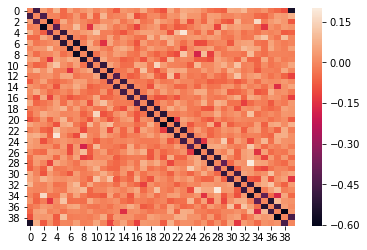

In [239]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.heatmap(wN.reshape(L,L))
plt.show()
#plt.imshow(wN.reshape(40,40))
#plt.show()

Gir mening at den fordeler verdiene i w sånn, fordi 0.5^2 + 0.5^2 er mindre enn 1^2 + 1^2 

Det at Lasso er mer riktig er ikke fordi den henter det ut fra dataen, men pga. prioren.

Men er variansen 0 her egentlig?


### The Distribution over $\vec{w}$

Since we now have the full posterior $P(\vec{w}|D)$, we can see how the probability changes as we move away from the MAP estimate, i.e. how confident we would be in points near $\vec{w}_{MAP}$.


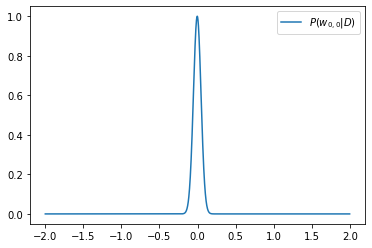

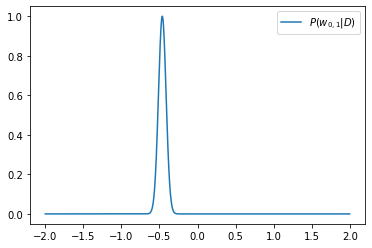

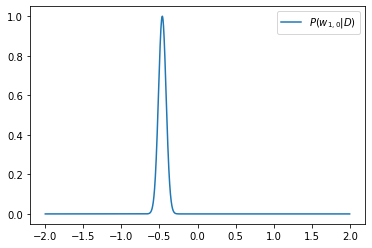

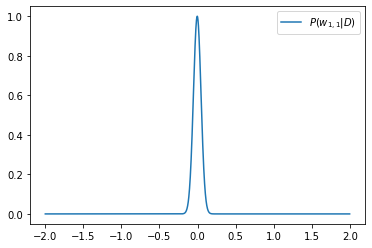

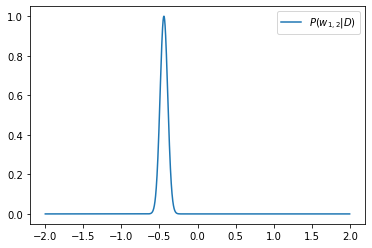

In [240]:
dw = 0.001
w_range = np.arange(-2,2, dw)

#print(w_range)
def Pw(index1,index2):
    
    index = index1*L + index2
    vec = wN.copy()
    
    logs = np.zeros(len(w_range))
    for k in range(len(w_range)):
        w = w_range[k]
        vec[index] = w
        logs[k] = -0.5 * np.dot(np.dot((vec - wN).T, VN_inv),vec - wN)
    
    logs -= np.max(logs)
    P = np.exp(logs)
    return P 

def plot_w_distribution(index1,index2,show=True):
    P = Pw(index1,index2)
    plt.plot(w_range,P, label="$P(w_{%.i,%.i}|D)$" % (index1,index2))
    plt.legend()
    if show:
        plt.show()
    
plot_w_distribution(0,0)
plot_w_distribution(0,1)
plot_w_distribution(1,0)
plot_w_distribution(1,1)
plot_w_distribution(1,2)



### Credible Intervals

We will use the show the 90 % HDI (Highest Density Interval) which means the region that contains 90 % of the probability mass, where all points in the region are higher than the ones outside. 
This area is not necessarily contiguous if the PDF is multimodal.

The algorithm used to find the HDI region is by thinking of turning the curve upside down and filling it with water drop by drop.

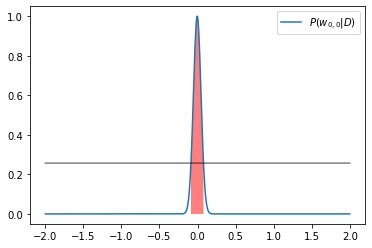

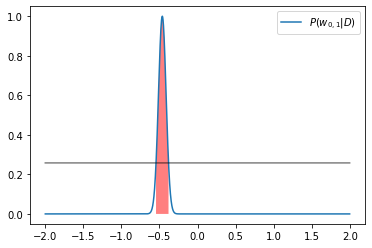

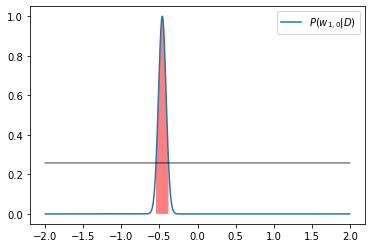

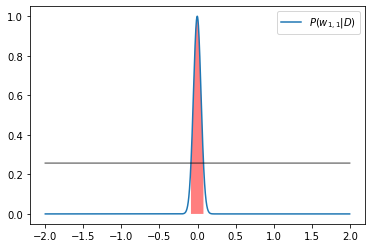

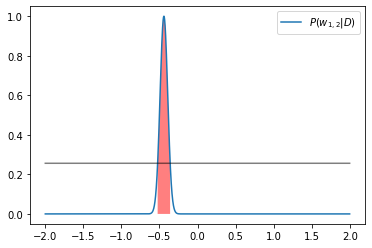

In [241]:

def credible_interval(index1, index2):
    P_ = Pw(index1,index2)
    # normalize
    P_normed = P_ / np.sum(P_)
    
    # Water filling algorithm:
    #points = np.zeros_like(P_normed, dtype=np.int)
    points_taken= []
    points = []
    done = False
    t = 0
    while not done:
        best=0
        bestindex=0
        for i in range(len(P_normed)-1):
            if i not in points_taken:
                val = P_normed[i]
                if val > best:
                    best = val
                    bestindex = i
        points_taken.append(bestindex)
        points.append(best)
        if np.sum(points) >= 0.9:
            done=True
    
    points_taken = np.array(points_taken, dtype=np.int)
    argsorted = np.argsort(points_taken)

    points_taken = points_taken[argsorted]
    
    
    plot_w_distribution(index1,index2,show=False)
    first_lastw = [w_range[points_taken[0]], w_range[points_taken[-1]]]
    first_lastP = [P_[points_taken[0]], P_[points_taken[-1]]]

    
    fill = np.zeros(len(points_taken)+2)
    fill[1:-1] = P_[points_taken]
    
    w_range_fill = np.zeros_like(fill)
    w_range_fill[1:-1] = w_range[points_taken]
    w_range_fill[0] = w_range_fill[1]
    w_range_fill[-1] = w_range_fill[-2]
    
    plt.fill(w_range_fill,fill,facecolor="red",alpha=0.5)
    
    line = np.ones(len(w_range))*P_[points_taken[0]]
    #plt.scatter(w_range[points_taken], P_[points_taken])
    #plt.plot(first_lastw, first_lastP, color="k")
    plt.plot(w_range,line, "k", alpha=0.5)
    plt.show()
    
credible_interval(0,0)
credible_interval(0,1)
credible_interval(1,0)
credible_interval(1,1)
credible_interval(1,2)

### Test data




In [242]:
test_states=np.random.choice([-1, 1], size=(1000,L))
# calculate Ising test energies
test_energies=ising_energies(test_states)

# remapping states:
test_states = np.einsum('bi,bo->bio',test_states,test_states)
test_states = test_states.reshape(test_states.shape[0],-1)

predicted_energies = np.dot(test_states, wN)


### R^2 - coefficient of determination
y_true_avg = np.mean(test_energies)
residuals = predicted_energies - test_energies
u = np.dot(residuals,residuals)
v = test_energies - y_true_avg
v = np.dot(v,v)

R_squared = 1 - u/v

print(R_squared)


0.7646067747606656


## When $\sigma^2$ is not assumed:

Noise is not necessarily constant, e.g. if one measures large variations in temperature and the temperature affects the instruments, the noise might not be constant with respect to temperature.


## The 2d Ising model
### Loading Ising model data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

def read_t(t,root="/home/samknu/MyRepos/MLProjectIsingModel/data/IsingData/"):
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
    return np.unpackbits(data).astype(int).reshape(-1,1600)

temperatures = np.arange(0.25, 4., step=0.25)   